/tmp/ipykernel_22435/26183796.py:94: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.SecondLocator'>
  ax.locator_params(axis="x", nbins=12)


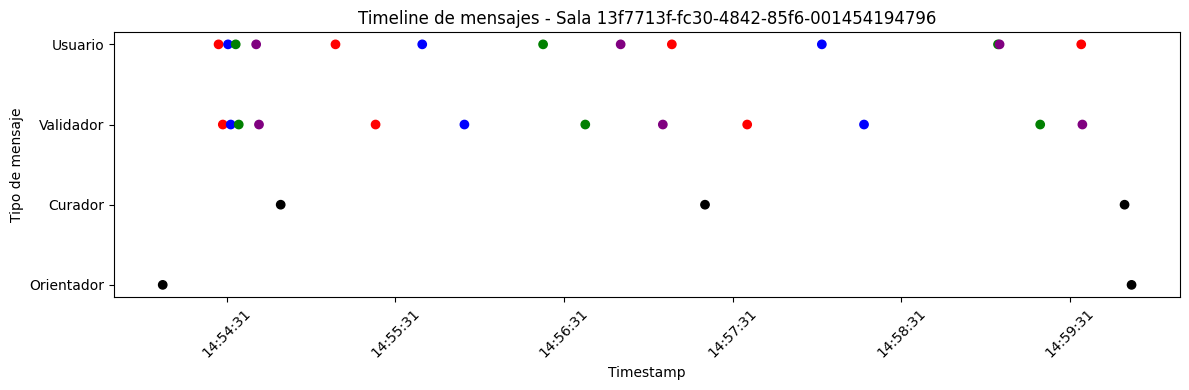

/tmp/ipykernel_22435/26183796.py:94: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.SecondLocator'>
  ax.locator_params(axis="x", nbins=12)


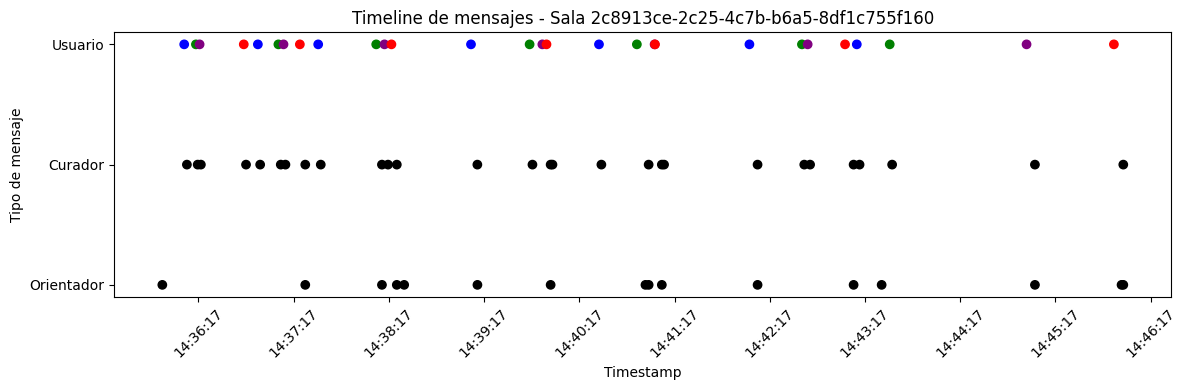

/tmp/ipykernel_22435/26183796.py:94: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.SecondLocator'>
  ax.locator_params(axis="x", nbins=12)


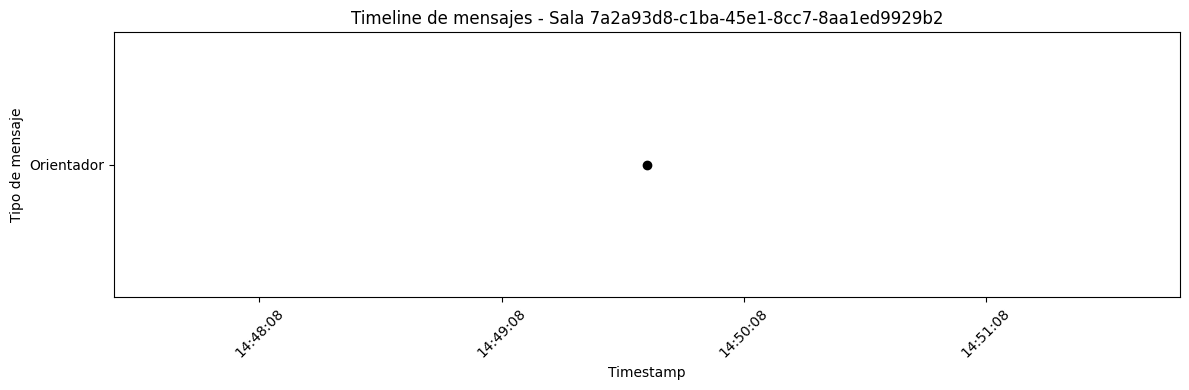

/tmp/ipykernel_22435/26183796.py:94: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.SecondLocator'>
  ax.locator_params(axis="x", nbins=12)


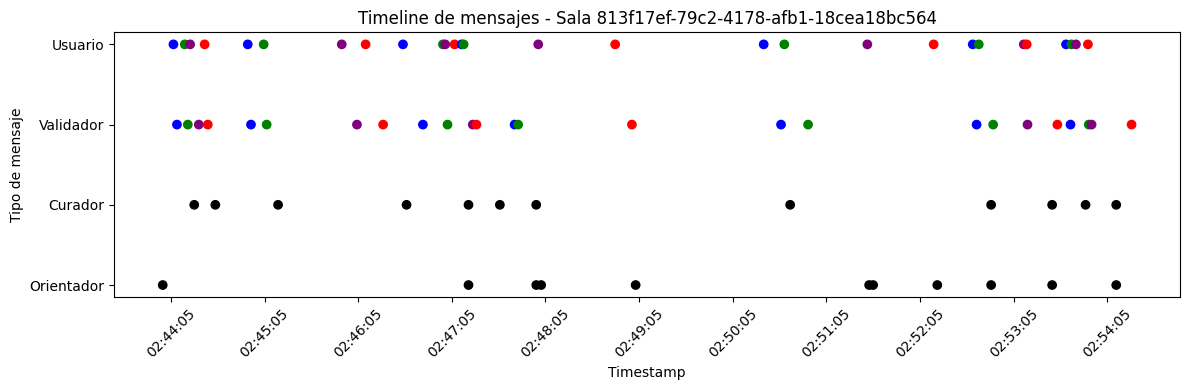

/tmp/ipykernel_22435/26183796.py:94: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.SecondLocator'>
  ax.locator_params(axis="x", nbins=12)


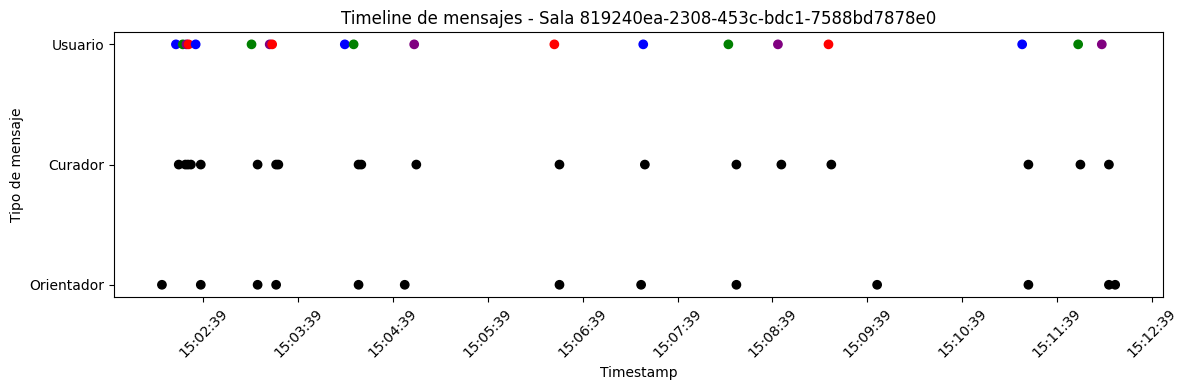

/tmp/ipykernel_22435/26183796.py:94: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.SecondLocator'>
  ax.locator_params(axis="x", nbins=12)


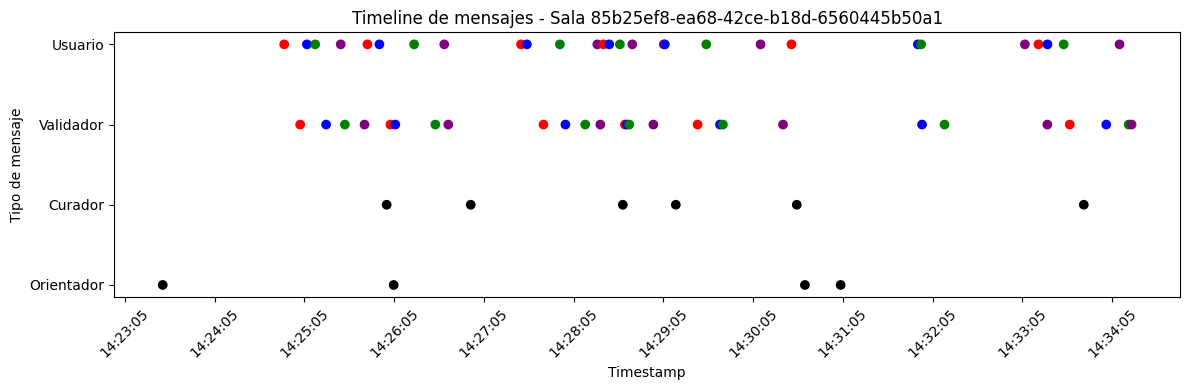

/tmp/ipykernel_22435/26183796.py:94: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.SecondLocator'>
  ax.locator_params(axis="x", nbins=12)


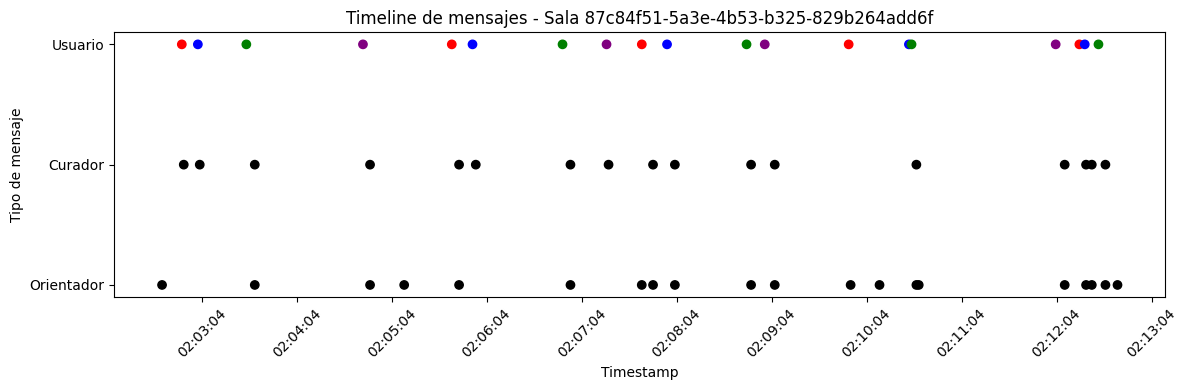

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ============================================
#  CARGA Y PREPROCESO
# ============================================

data = pd.read_csv("mensajes_sesion2.csv")
data["created_at"] = pd.to_datetime(data["created_at"])

def get_role(row):
    if row["sender_type"] == "user":
        return "Usuario"
    if row["sender_type"] == "agent":
        return row["agent_name"] if pd.notna(row["agent_name"]) else "Agente"
    return "Desconocido"

data["role"] = data.apply(get_role, axis=1)
data["role"] = data["role"].str.capitalize()

# ORDEN GLOBAL IDEAL
full_role_order = ["Orientador", "Curador", "Validador", "Usuario"]

# Convertimos a categoría con este orden
data["role"] = pd.Categorical(data["role"], categories=full_role_order, ordered=True)

# Orden temporal
data = data.sort_values(by=["room_session_id", "created_at"]).reset_index(drop=True)


# ============================================
#  MAPEO DE COLORES CICLICOS (usuario–validador)
# ============================================

color_cycle = ["red", "blue", "green", "purple"]
color_map = {}
current_color_index = 0

for idx, row in data.iterrows():
    if row["role"] == "Usuario":
        user_id = row["id"]
        color_map[user_id] = color_cycle[current_color_index]
        current_color_index = (current_color_index + 1) % len(color_cycle)

def assign_color(row):
    if row["role"] == "Usuario":
        return color_map.get(row["id"])

    if row["role"] == "Validador" and pd.notna(row["parent_message_id"]):
        parent = int(row["parent_message_id"])
        return color_map.get(parent, "black")

    return "black"

data["color"] = data.apply(assign_color, axis=1)


# ============================================
#  PLOT POR SALA (roles dinámicos por sala)
# ============================================

salas = data["room_session_id"].unique()

for sala in salas:
    df_sala = data[data["room_session_id"] == sala].copy()

    # Detectar roles presentes en la sala
    roles_presentes = [r for r in full_role_order if r in df_sala["role"].unique()]

    # Reconvertir categoría solo con los roles que existen
    df_sala["role"] = pd.Categorical(df_sala["role"], categories=roles_presentes, ordered=True)

    plt.figure(figsize=(12, 4))

    df_sala["role_code"] = df_sala["role"].cat.codes

    plt.scatter(
        df_sala["created_at"],
        df_sala["role_code"],
        c=df_sala["color"]
    )

    plt.yticks(
        ticks=range(len(roles_presentes)),
        labels=roles_presentes
    )

    ax = plt.gca()

    # === Marcas del tiempo cada 60 segundos ===
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=60))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.locator_params(axis="x", nbins=12)

    plt.title(f"Timeline de mensajes - Sala {sala}")
    plt.xlabel("Timestamp")
    plt.ylabel("Tipo de mensaje")

    # Rotar solo si hay pocos ticks
    if len(ax.get_xticks()) <= 12:
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


In [1]:
import pandas as pd
from pathlib import Path

# ===========================
# Configuración
# ===========================
CSV_PATH = "mensajes_sesion2.csv"   # ruta a tu CSV
OUTPUT_FOLDER = "salas_txt"         # carpeta donde se guardarán los .txt
Path(OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

# ===========================
# Carga de datos
# ===========================
data = pd.read_csv(CSV_PATH)

# Convertir timestamp a datetime
data["created_at"] = pd.to_datetime(data["created_at"])

# ===========================
# Función para obtener rol/nombre
# ===========================
def get_sender_name(row):
    if row["sender_type"] == "user":
        return f"[USUARIO] {row['user_id']}"
    elif row["sender_type"] == "agent":
        agent_name = row["agent_name"] if pd.notna(row["agent_name"]) else "AGENTE"
        return f"[{agent_name}]"
    else:
        return "[DESCONOCIDO]"

data["sender_label"] = data.apply(get_sender_name, axis=1)

# ===========================
# Procesar por sala
# ===========================
salas = data["room_session_id"].unique()

for sala in salas:
    df_sala = data[data["room_session_id"] == sala].sort_values("created_at")

    lines = []
    for _, row in df_sala.iterrows():
        # Extraer solo hora:minuto:segundo
        timestamp_str = row["created_at"].strftime("%H:%M:%S")
        content = row["content"] if pd.notna(row["content"]) else ""
        line = f"{row['sender_label']} - {timestamp_str}: \"{content}\""
        lines.append(line)

    # Guardar en .txt
    output_path = Path(OUTPUT_FOLDER) / f"sala_{sala}.txt"
    with open(output_path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print(f"Archivo generado: {output_path}")


Archivo generado: salas_txt/sala_2c8913ce-2c25-4c7b-b6a5-8df1c755f160.txt
Archivo generado: salas_txt/sala_813f17ef-79c2-4178-afb1-18cea18bc564.txt
Archivo generado: salas_txt/sala_13f7713f-fc30-4842-85f6-001454194796.txt
Archivo generado: salas_txt/sala_87c84f51-5a3e-4b53-b325-829b264add6f.txt
Archivo generado: salas_txt/sala_85b25ef8-ea68-42ce-b18d-6560445b50a1.txt
Archivo generado: salas_txt/sala_7a2a93d8-c1ba-45e1-8cc7-8aa1ed9929b2.txt
Archivo generado: salas_txt/sala_819240ea-2308-453c-bdc1-7588bd7878e0.txt


In [1]:
import pandas as pd
import numpy as np

# Cargar CSV
df = pd.read_csv('Test de Usabilidad para Agente de Chat.csv') 

# Listado de columnas cuantitativas (excepto texto libre)
quant_cols = [
    "Creo que podría usar el agente de chat frecuentemente",
    "Encuentro el agente de chat innecesariamente complejo",
    "Creo que el agente de chat fue fácil de utilizar",
    "Creo que necesitaría ayuda de una persona con conocimientos técnicos para usar el agente de chat",
    "Las funciones del agente de chat están bien integradas",
    "Creo que el agente de chat es muy inconsistente",
    "Imagino que la mayoría de la gente aprendería a usar el agente de chat en forma muy rápida",
    "Encuentro que el agente de chat es muy difícil de usar",
    "Me siento confiado al usar el agente de chat",
    "Necesité aprender muchas cosas antes de ser capaz de usar el agente de chat",
    "Los mensajes del agente de chat me motivaron a explicar mis ideas con mayor profundidad.",
    "El agente de chat me entregó indicaciones útiles para fortalecer mis argumentos.",
    "El agente de chat actuó como mediador para que los participantes pudieran apreciar distintos enfoques éticos o conceptuales.",
    "El agente de chat intervino en los momentos adecuados, sin entorpecer la conversación.",
    "Los comentarios del agente de chat resultaron útiles para la discusión."
]

# Calcular medias y desviaciones estándar
stats = df[quant_cols].agg(["mean", "std"]).T
stats

,mean,std
Creo que podría usar el agente de chat frecuentemente,3.444444,0.881917
Encuentro el agente de chat innecesariamente complejo,1.666667,1.118034
Creo que el agente de chat fue fácil de utilizar,4.333333,0.866025
Creo que necesitaría ayuda de una persona con conocimientos técnicos para usar el agente de chat,1.444444,0.726483
Las funciones del agente de chat están bien integradas,3.777778,0.833333
Creo que el agente de chat es muy inconsistente,2.444444,0.881917
Imagino que la mayoría de la gente aprendería a usar el agente de chat en forma muy rápida,4.444444,1.130388
Encuentro que el agente de chat es muy difícil de usar,1.333333,0.500000
Me siento confiado al usar el agente de chat,4.333333,0.500000
Necesité aprender muchas cosas antes de ser capaz de usar el agente de chat,1.444444,1.013794


In [2]:
# Ítems SUS en orden
sus_items = [
    "Creo que podría usar el agente de chat frecuentemente", # positivo
    "Encuentro el agente de chat innecesariamente complejo", # negativo
    "Creo que el agente de chat fue fácil de utilizar", # positivo
    "Creo que necesitaría ayuda de una persona con conocimientos técnicos para usar el agente de chat", # negativo
    "Las funciones del agente de chat están bien integradas", # positivo
    "Creo que el agente de chat es muy inconsistente", # negativo
    "Imagino que la mayoría de la gente aprendería a usar el agente de chat en forma muy rápida", # positivo
    "Encuentro que el agente de chat es muy difícil de usar", # negativo
    "Me siento confiado al usar el agente de chat", # positivo
    "Necesité aprender muchas cosas antes de ser capaz de usar el agente de chat" # negativo
]

sus_df = df[sus_items].copy()

# Identificar qué ítems son positivos (pos) y negativos (neg)
pos = [0, 2, 4, 6, 8]  # índices
neg = [1, 3, 5, 7, 9]

# Convertir a puntaje SUS
for i in pos:
    sus_df.iloc[:, i] = sus_df.iloc[:, i] - 1

for i in neg:
    sus_df.iloc[:, i] = 5 - sus_df.iloc[:, i]

# Puntaje total
df["SUS"] = sus_df.sum(axis=1) * 2.5

df["SUS"].describe()


count     9.000000
mean     80.000000
std      14.469796
min      52.500000
25%      70.000000
50%      82.500000
75%      90.000000
max      97.500000
Name: SUS, dtype: float64

In [3]:
q_beneficios = df["¿Qué es para ti lo más beneficioso de usar el agente de chat?"].dropna()
q_mejoras = df["¿Qué aspectos del agente de chat consideras que tienen que ser mejorados?"].dropna()

print("=== Respuestas: Beneficios ===")
for r in q_beneficios:
    print("-", r)

print("\n=== Respuestas: Mejoras ===")
for r in q_mejoras:
    print("-", r)

=== Respuestas: Beneficios ===
- Es un buen incentivo para mantener continuidad y fluidez en la conversación al buscar puntos de vista que tal vez no se hayan hablado
- Ver puntos de vista e integrarlos a mi respuesta
- Permite generar sintesis del chat y recomendaciones pertinentes, lo cual es útil
- Es una guía que puede orientar en un debate
- Que brinda otros factores a considerar, lo cual ayuda a mejorar nuestros argumentos y explorar otras posibiliades.
- Creo que cuando la conversacion se estancaba (no habian mensajes en un tiempo) hacia buenas intervenciones
- El hecho de que promueve la participación
- Es util porque te obliga y te insiste en intentar llegar a una respuesa concreta y un consenso entre los participantes

=== Respuestas: Mejoras ===
- a veces interviene muchas veces seguidas y no da tiempo para responder o no interviene en mucho tiempo y deja tiempos vacíos 
- Todo lo que es la entrada de las salas
- El agente interrumpe mucho y no es capaz de permitir que fluya